In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## preprocess and EDA


In [2]:
folder_path = "C:\\Users\\moran\\personal_projects\\vfm_car_finder\\VFM_car_finder\\scraped_chunks"  

# Get all CSV file paths in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Load and concatenate them into one DataFrame
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.shape)
combined_df.head()

(91493, 23)


,listing_id,upload_date,scrape_date,price,title,year_summary,owner_count,mileage,color,ownership,...,on_road_date,fuel_type,body_type,seats,horsepower,engine_volume,fuel_consumption,drive_type,drive_system,url
0,46544667,21/05/25,25/05/2025,289999,ג'יפ גרנד צ'ירוקי,2022,2,"70,000",כסוף,פרטית,...,05/2022,בנזין,פנאי-שטח,5,295,"3,604",10.00,4X4,NaN,https://www.yad2.co.il/vehicles/item/xh2tdvmd?...
1,72039716,09/01/25,25/05/2025,62900,מאזדה 2,2020,2,"88,000",אפור מטאלי,פרטית,...,01/2020,בנזין,האצ'בק,5,116,"1,496",20.83,4X2,NaN,https://www.yad2.co.il/vehicles/item/iizgzpne?...
2,65607492,08/05/25,25/05/2025,210000,ב מ וו סדרה 7,2018,3,"110,000",שחור,פרטית,...,06/2018,פלאג-אין בנזין,סדאן,5,326,"1,998",40.00,4X4,פלאג-אין,https://www.yad2.co.il/vehicles/item/vh8136jp?...
3,74300037,24/05/25,25/05/2025,46600,קיה ספורטז',2016,2,"182,000",אפור,פרטית,...,01/2016,בנזין,פנאי-שטח,5,133,"1,591",14.71,4X2,NaN,https://www.yad2.co.il/vehicles/item/pxog95kb?...
4,82186481,16/05/25,25/05/2025,80000,מרצדס-בנץ CLA,2016,5,"170,000",לבן,פרטית,...,03/2016,בנזין,סדאן,5,211,"1,991",17.24,4X2,NaN,https://www.yad2.co.il/vehicles/item/nxv8x4jj?...


 remove duplicates entries by listing_id
 encode unknown price to nan and remove those entries because price is the target feature

In [3]:
process_df = combined_df.copy()
process_df = process_df.drop_duplicates(subset='listing_id')
process_df = process_df.reset_index(drop=True)

# Remove unwanted characters (e.g., currency symbols, commas, spaces)
process_df['price'] = process_df['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)

# Convert to numeric (this will set invalid entries to NaN automatically)
process_df['price'] = pd.to_numeric(process_df['price'], errors='coerce')

print('num of entries removed',process_df['price'].isnull().sum())
process_df = process_df.dropna(subset=['price'])
process_df.shape

num of entries removed 2377


(41944, 23)

In [4]:
null_summary = process_df.isnull().sum().to_frame(name='null_count')
null_summary['percent_null'] = (null_summary['null_count'] / len(process_df)) * 100

print(null_summary)

                    null_count  percent_null
listing_id                   0      0.000000
upload_date                  0      0.000000
scrape_date                  0      0.000000
price                        0      0.000000
title                        0      0.000000
year_summary                 0      0.000000
owner_count                  0      0.000000
mileage                      0      0.000000
color                       11      0.026225
ownership                    7      0.016689
test_date                 6331     15.093935
previous_ownership       16542     39.438299
transmission                 0      0.000000
on_road_date              6016     14.342933
fuel_type                    0      0.000000
body_type                    0      0.000000
seats                        0      0.000000
horsepower                   0      0.000000
engine_volume             2859      6.816231
fuel_consumption          9786     23.331108
drive_type                   0      0.000000
drive_syst

 remove features with around 40% nan or higher

In [5]:
process_df = process_df.drop(['previous_ownership', 'drive_system'], axis=1)
process_df.shape

(41944, 21)

make sure the numeric features are in the right type

In [6]:
# Step 1: Remove commas and extra spaces
process_df['mileage'] = process_df['mileage'].astype(str).str.replace(',', '').str.strip()
process_df['engine_volume'] = process_df['engine_volume'].astype(str).str.replace(',', '').str.strip()

# Step 2: Convert to numeric (now clean)
process_df['mileage'] = pd.to_numeric(process_df['mileage'], errors='coerce')
process_df['engine_volume'] = pd.to_numeric(process_df['engine_volume'], errors='coerce')

process_df.describe()

,listing_id,price,year_summary,owner_count,mileage,seats,horsepower,engine_volume,fuel_consumption
count,4.194400e+04,4.194400e+04,41944.000000,41944.000000,4.194400e+04,41944.000000,41944.000000,39085.000000,32158.000000
mean,6.606024e+07,9.805704e+04,2017.607310,2.019907,1.222035e+05,5.131723,159.639019,1760.834284,18.919575
std,1.558577e+07,1.130809e+06,5.182387,1.296241,8.729818e+04,0.748063,80.310283,695.078093,10.751425
min,3.100388e+07,1.000000e+00,1987.000000,0.000000,0.000000e+00,1.000000,10.000000,0.000000,4.170000
25%,5.279666e+07,2.800000e+04,2015.000000,1.000000,6.193075e+04,5.000000,110.000000,1388.000000,13.890000
50%,6.619020e+07,6.950000e+04,2019.000000,2.000000,1.115000e+05,5.000000,141.000000,1591.000000,16.670000
75%,7.890955e+07,1.100000e+05,2022.000000,3.000000,1.700000e+05,5.000000,178.000000,1997.000000,20.410000
max,9.999225e+07,1.600000e+08,2025.000000,10.000000,2.958000e+06,13.000000,1020.000000,7269.000000,142.860000


informative process on categorical features

In [7]:
def num_of_catagoric_above(column_name, trash_hold):
    
    # Count occurrences of each category
    category_counts = process_df[column_name].value_counts()
    
    # Filter and count categories that occur more than 50 times
    num_categories_over = (category_counts > trash_hold).sum()
    return num_categories_over
    


In [8]:
print(len(process_df['title'].unique()))
print("num of car models above 50: ", num_of_catagoric_above("title", 50))

758
num of car models above 50:  184


In [9]:
print(len(process_df['color'].unique()))
print("num of car colors above 50: ", num_of_catagoric_above("color", 50))

52
num of car colors above 50:  39


In [10]:
print('unique transmission types: ',len(process_df['transmission'].unique()),', categories: ', process_df['transmission'].unique())
print('unique fuel types: ',len(process_df['fuel_type'].unique()),', categories: ', process_df['fuel_type'].unique())
print('unique body_type types: ',len(process_df['body_type'].unique()), ', categories: ', process_df['body_type'].unique())
print('unique drive_type types: ',len(process_df['drive_type'].unique()), ', categories: ', process_df['drive_type'].unique())
print('unique ownership types: ',len(process_df['ownership'].unique()), ', categories: ', process_df['ownership'].unique())


unique transmission types:  2 , categories:  ['אוטומטי' 'ידני']
unique fuel types:  7 , categories:  ['בנזין' 'פלאג-אין בנזין' 'חשמלי' 'היברידי בנזין' 'דיזל' 'פלאג-אין דיזל'
 'היברידי דיזל']
unique body_type types:  24 , categories:  ['פנאי-שטח' "האצ'בק" 'סדאן' 'סטיישן / טורר' 'קבריולט' 'וואן גדול'
 'מיניוואן גדול (7+ מושבים)' 'קומבי לנוסעים' 'ליפטבק' 'פסטבק' 'דאבל קבינה'
 'קומבי' 'וואן מסחרי' 'קופה' 'מיניוואן קומפקטי' "ג'יפ שטח קשוח"
 'וואן נוסעים' 'קומבי מסחרי' 'רודסטר' 'חד קבינה' 'טנדר' 'וואן מגורים'
 'מיניוואן / MPV' 'טרגה']
unique drive_type types:  2 , categories:  ['4X4' '4X2']
unique ownership types:  14 , categories:  ['פרטית' 'ליסינג' 'חברה' 'ללא רישום בעלות קודמת' 'השכרה' 'ייבוא מקביל'
 'מונית' 'ייבוא אישי' 'השכרה / החכר' 'לימוד נהיגה' 'ממשלתי' 'או"ם' nan
 'סוחר רכב']


add an informative feature of the age of the car in months 

In [11]:
# Step 1: Parse upload_date (format: yy/mm/dd)
process_df['upload_date'] = pd.to_datetime(process_df['upload_date'], format='%d/%m/%y', errors='coerce')

# Step 2: Parse on_road_date (format: mm/yyyy) or fallback to year_summary (use June)
def parse_on_road(row):
    if pd.notnull(row['on_road_date']):
        return pd.to_datetime(f"01/{row['on_road_date']}", format='%d/%m/%Y', errors='coerce')
    elif pd.notnull(row['year_summary']):
        return pd.to_datetime(f"01/01/{row['year_summary']}", format='%d/%m/%Y', errors='coerce')
    return pd.NaT

process_df['on_road_date'] = process_df.apply(parse_on_road, axis=1)

# Step 3: Calculate months on road
def calculate_months_on_road(row):
    if pd.isnull(row['upload_date']) or pd.isnull(row['on_road_date']):
        return None
    delta = (row['upload_date'].year - row['on_road_date'].year) * 12
    delta += row['upload_date'].month - row['on_road_date'].month
    return delta

process_df['months_on_road'] = process_df.apply(calculate_months_on_road, axis=1)

In [12]:
temp_df = process_df[process_df['upload_date'] <= process_df['on_road_date']]
temp_df

,listing_id,upload_date,scrape_date,price,title,year_summary,owner_count,mileage,color,ownership,...,on_road_date,fuel_type,body_type,seats,horsepower,engine_volume,fuel_consumption,drive_type,url,months_on_road
23,95846216,2025-03-27,25/05/2025,280000.0,אאודי Q3,2025,0,0,לבן מטאלי,פרטית,...,2025-04-01,בנזין,פנאי-שטח,5,150,1498.0,14.08,4X2,https://www.yad2.co.il/vehicles/item/rfx7q5g8?...,-1
56,48289449,2024-11-14,25/05/2025,785000.0,מרצדס-בנץ GLE Coupe,2024,0,36000,אפור מטאלי,פרטית,...,2024-12-01,בנזין,פנאי-שטח,5,435,2999.0,NaN,4X4,https://www.yad2.co.il/vehicles/item/km6g7uvl?...,-1
63,43297637,2025-01-20,25/05/2025,1870.0,יונדאי קונה,2025,0,0,לבן פנינה,פרטית,...,2025-02-01,היברידי בנזין,פנאי-שטח,5,141,1580.0,23.26,4X2,https://www.yad2.co.il/vehicles/item/fnfpxd8h?...,-1
463,75449617,2025-01-01,30/06/2025,99900.0,יודו יודו 3,2025,0,0,לבן,ללא רישום בעלות קודמת,...,2025-01-01,חשמלי,האצ'בק,5,94,NaN,NaN,4X2,https://www.yad2.co.il/vehicles/item/yy3jio0h?...,0
707,72352955,2024-12-23,30/06/2025,519000.0,טויוטה לנד קרוזר,2025,0,0,לבן פנינה,ללא רישום בעלות קודמת,...,2025-01-01,היברידי בנזין,פנאי-שטח,5,326,2393.0,9.80,4X4,https://www.yad2.co.il/vehicles/item/oxy22nqa?...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43043,41146061,2024-12-19,28/05/2025,142000.0,טויוטה יאריס,2025,0,0,לבן מטאלי,ללא רישום בעלות קודמת,...,2025-03-01,היברידי בנזין,האצ'בק,5,92,1490.0,35.71,4X2,https://www.yad2.co.il/vehicles/item/gq3fur9m?...,-3
43249,64957542,2025-04-24,28/05/2025,1750.0,צ׳רי טיגו 7 פרו,2025,0,0,שחור מטאלי,פרטית,...,2025-05-01,פלאג-אין בנזין,פנאי-שטח,5,143,1499.0,55.56,4X2,https://www.yad2.co.il/vehicles/item/e9hmotua?...,-1
43455,47022060,2025-05-13,28/05/2025,205000.0,סמארט #3,2025,1,0,לבן,פרטית,...,2025-06-01,חשמלי,פנאי-שטח,5,272,NaN,NaN,4X2,https://www.yad2.co.il/vehicles/item/np4jw1wu?...,-1
44241,76995321,2025-04-30,24/05/2025,829000.0,לנד רובר ריינג' רובר ספורט,2025,0,0,אפור,פרטית,...,2025-05-01,בנזין,פנאי-שטח,5,400,2997.0,8.77,4X4,https://www.yad2.co.il/vehicles/item/r5qib3ca?...,-1


drop entries with invalid information about the on road date 

In [13]:
process_df = process_df[~process_df['listing_id'].isin(temp_df['listing_id'])]
process_df.shape

(41617, 22)

In [14]:
process_df['months_on_road'].describe()

count    41617.000000
mean        88.396761
std         61.513227
min          0.000000
25%         40.000000
50%         74.000000
75%        124.000000
max        456.000000
Name: months_on_road, dtype: float64

 the data is full of lising and loan prices (price per month) so they need to be dropped
 i chose to do it by a strict role that consider the age of the car and its price

In [15]:
# Ensure numeric types
process_df['price'] = pd.to_numeric(process_df['price'], errors='coerce')
process_df['months_on_road'] = pd.to_numeric(process_df['months_on_road'], errors='coerce')

# Apply the filter
condition = (((process_df['price'] < 10000) & (process_df['months_on_road'] < 60)) | (process_df['price'] > 1000000))
process_df = process_df[~condition]  # Drop rows matching the condition

# Optional: reset index
process_df = process_df.reset_index(drop=True)
process_df

,listing_id,upload_date,scrape_date,price,title,year_summary,owner_count,mileage,color,ownership,...,on_road_date,fuel_type,body_type,seats,horsepower,engine_volume,fuel_consumption,drive_type,url,months_on_road
0,46544667,2025-05-21,25/05/2025,289999.0,ג'יפ גרנד צ'ירוקי,2022,2,70000,כסוף,פרטית,...,2022-05-01,בנזין,פנאי-שטח,5,295,3604.0,10.00,4X4,https://www.yad2.co.il/vehicles/item/xh2tdvmd?...,36
1,72039716,2025-01-09,25/05/2025,62900.0,מאזדה 2,2020,2,88000,אפור מטאלי,פרטית,...,2020-01-01,בנזין,האצ'בק,5,116,1496.0,20.83,4X2,https://www.yad2.co.il/vehicles/item/iizgzpne?...,60
2,65607492,2025-05-08,25/05/2025,210000.0,ב מ וו סדרה 7,2018,3,110000,שחור,פרטית,...,2018-06-01,פלאג-אין בנזין,סדאן,5,326,1998.0,40.00,4X4,https://www.yad2.co.il/vehicles/item/vh8136jp?...,83
3,74300037,2025-05-24,25/05/2025,46600.0,קיה ספורטז',2016,2,182000,אפור,פרטית,...,2016-01-01,בנזין,פנאי-שטח,5,133,1591.0,14.71,4X2,https://www.yad2.co.il/vehicles/item/pxog95kb?...,112
4,82186481,2025-05-16,25/05/2025,80000.0,מרצדס-בנץ CLA,2016,5,170000,לבן,פרטית,...,2016-03-01,בנזין,סדאן,5,211,1991.0,17.24,4X2,https://www.yad2.co.il/vehicles/item/nxv8x4jj?...,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40551,59440427,2025-05-15,24/05/2025,155900.0,טסלה מודל 3,2021,1,40000,לבן שנהב,פרטית,...,2021-08-01,חשמלי,פסטבק,5,498,NaN,NaN,4X4,https://www.yad2.co.il/vehicles/item/9bq9lplx?...,45
40552,69161608,2025-05-07,24/05/2025,82000.0,סיאט אטקה,2019,2,80000,לבן,פרטית,...,2019-02-01,בנזין,פנאי-שטח,5,150,1395.0,18.18,4X2,https://www.yad2.co.il/vehicles/item/bkslyzsz?...,75
40553,49983040,2025-04-10,24/05/2025,265000.0,לנד רובר ריינג' רובר ספורט,2018,2,100000,לבן שנהב,פרטית,...,2018-04-01,דיזל,פנאי-שטח,5,258,2993.0,13.70,4X4,https://www.yad2.co.il/vehicles/item/5r2la3ci?...,84
40554,83886243,2025-05-20,24/05/2025,166000.0,סובארו פורסטר,2023,1,31000,שחור,פרטית,...,2023-05-01,בנזין,פנאי-שטח,5,182,2498.0,14.08,4X4,https://www.yad2.co.il/vehicles/item/5wplx7f2?...,24


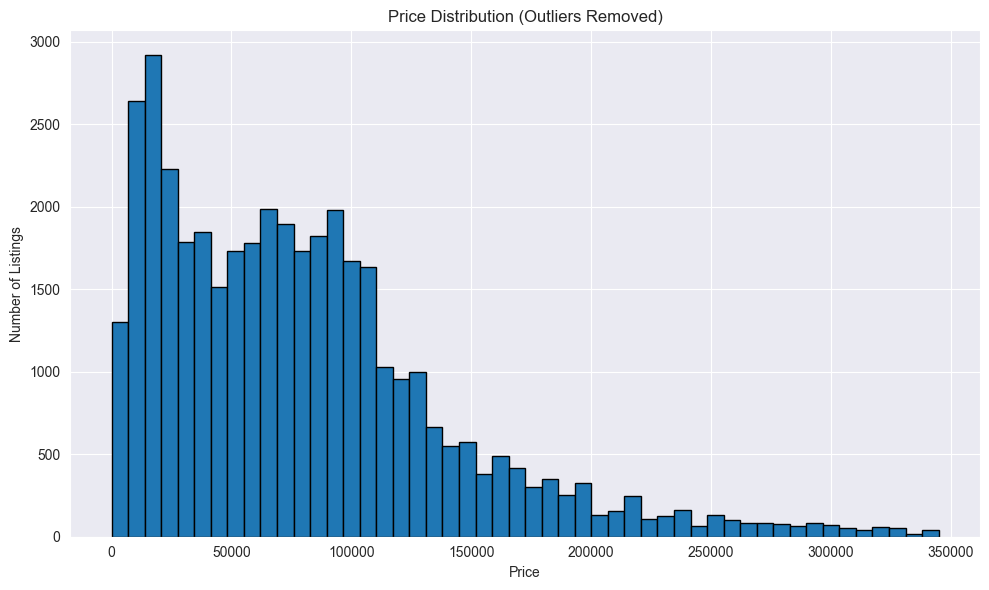

In [16]:
price_data = process_df['price']

# Calculate IQR boundaries
q1 = price_data.quantile(0.25)
q3 = price_data.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

# Filter out extreme outliers
filtered_prices = price_data[(price_data >= lower_bound) & (price_data <= upper_bound)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_prices, bins=50, edgecolor='black')
plt.title('Price Distribution (Outliers Removed)')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.tight_layout()
plt.show()

## this part is going to investigate the connections between the features to the price 
we are going to use a data set without extreme observation so the visualization will be more informative

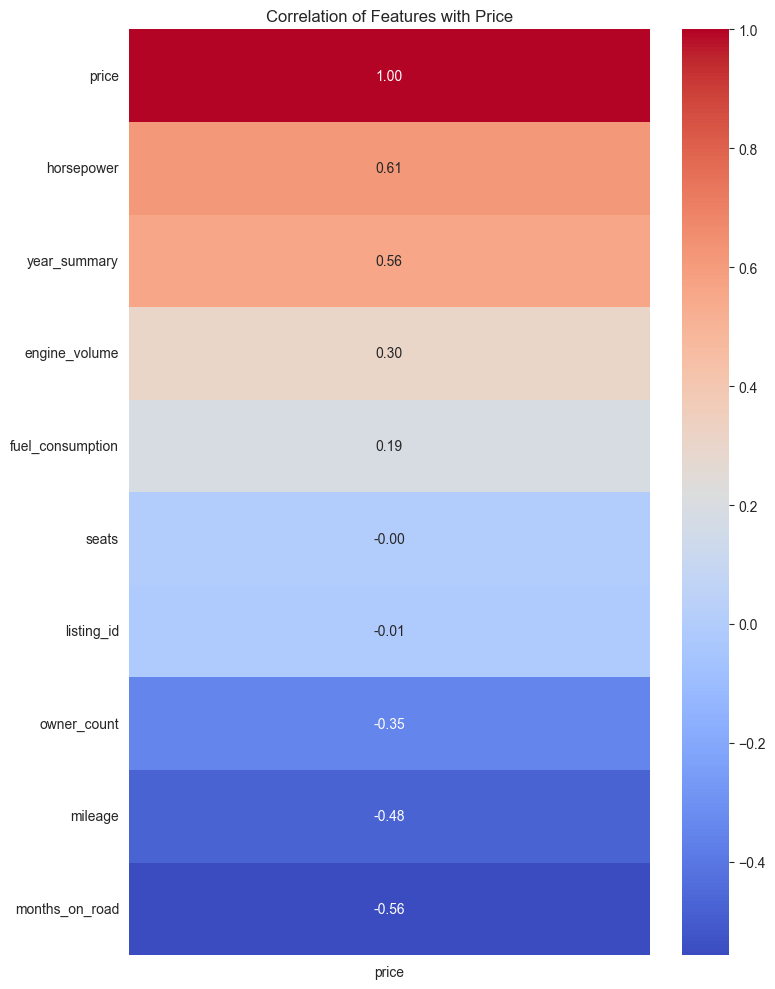

In [17]:
# Compute correlation with price
correlation_map = process_df.corr(numeric_only=True)

# Extract only the correlation values with 'price'
price_correlations = correlation_map[['price']].sort_values(by='price', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(price_correlations, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation of Features with Price')
plt.tight_layout()
plt.show()

In [18]:
price_data = process_df['price'].dropna()

# Calculate IQR
q1 = price_data.quantile(0.25)
q3 = price_data.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

# Filter out outliers
vis_df = process_df[(process_df['price'] >= lower_bound) & (process_df['price'] <= upper_bound)]

# Optional: reset index
vis_df = vis_df.reset_index(drop=True)


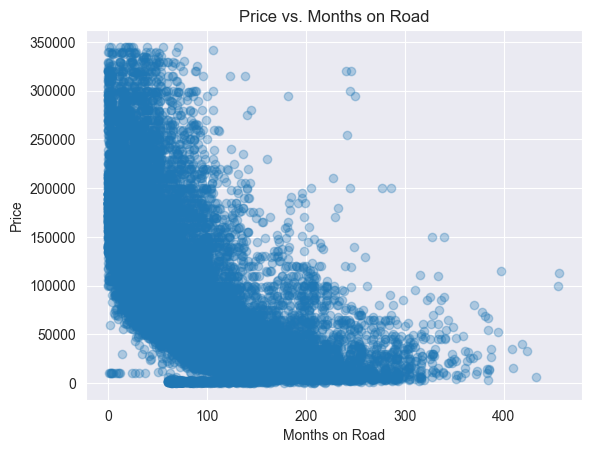

In [19]:
plt.scatter(vis_df['months_on_road'], vis_df['price'], alpha=0.3)
plt.title('Price vs. Months on Road')
plt.xlabel('Months on Road')
plt.ylabel('Price')
plt.grid(True)
plt.show()

in the next visualization i check if different car models price vs milage behave the same 

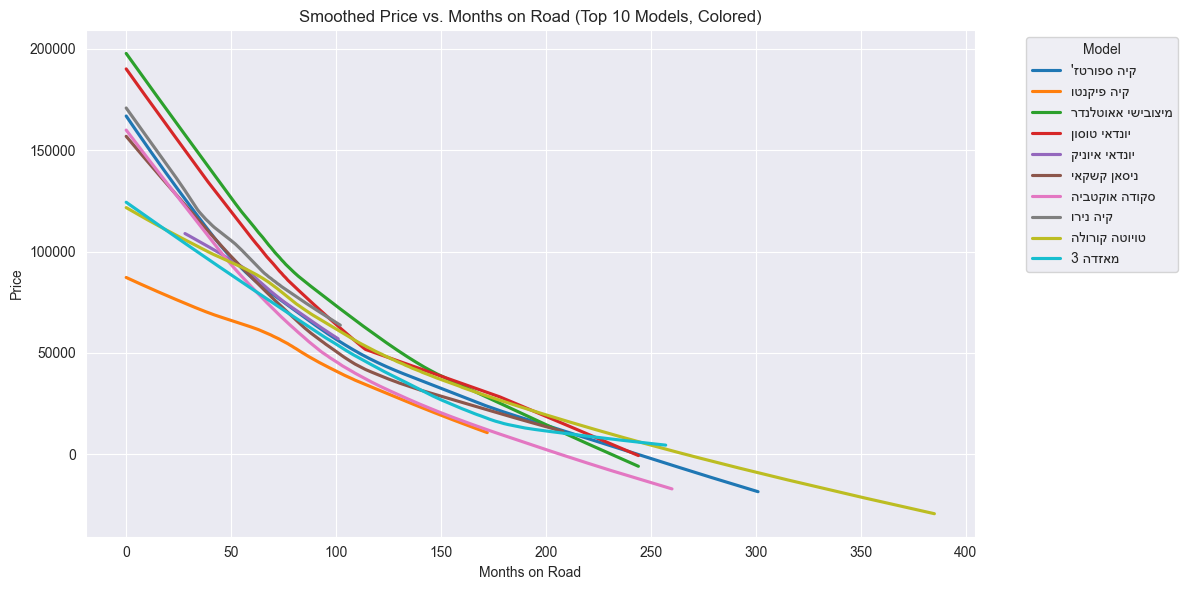

In [20]:
def reverse_hebrew(text):
    return ''.join(reversed(text)) if isinstance(text, str) else text

# Create a copy for manipulation
title_df = vis_df.copy()

# Keep only top 10 make_model values
top_titles = title_df['title'].value_counts().head(10).index
title_df = title_df[title_df['title'].isin(top_titles)]

plt.figure(figsize=(12, 6))
# Plot LOWESS trend for each of the top 10 models
for model in title_df['title'].unique():
    model_df = title_df[title_df['title'] == model]
    sns.regplot(
        data=model_df,
        x='months_on_road',
        y='price',
        lowess=True,
        scatter=False,
        label=reverse_hebrew(model)

    )

plt.title('Smoothed Price vs. Months on Road (Top 10 Models, Colored)')
plt.xlabel('Months on Road')
plt.ylabel('Price')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

check if a transformation on the milage can simplify the relationship

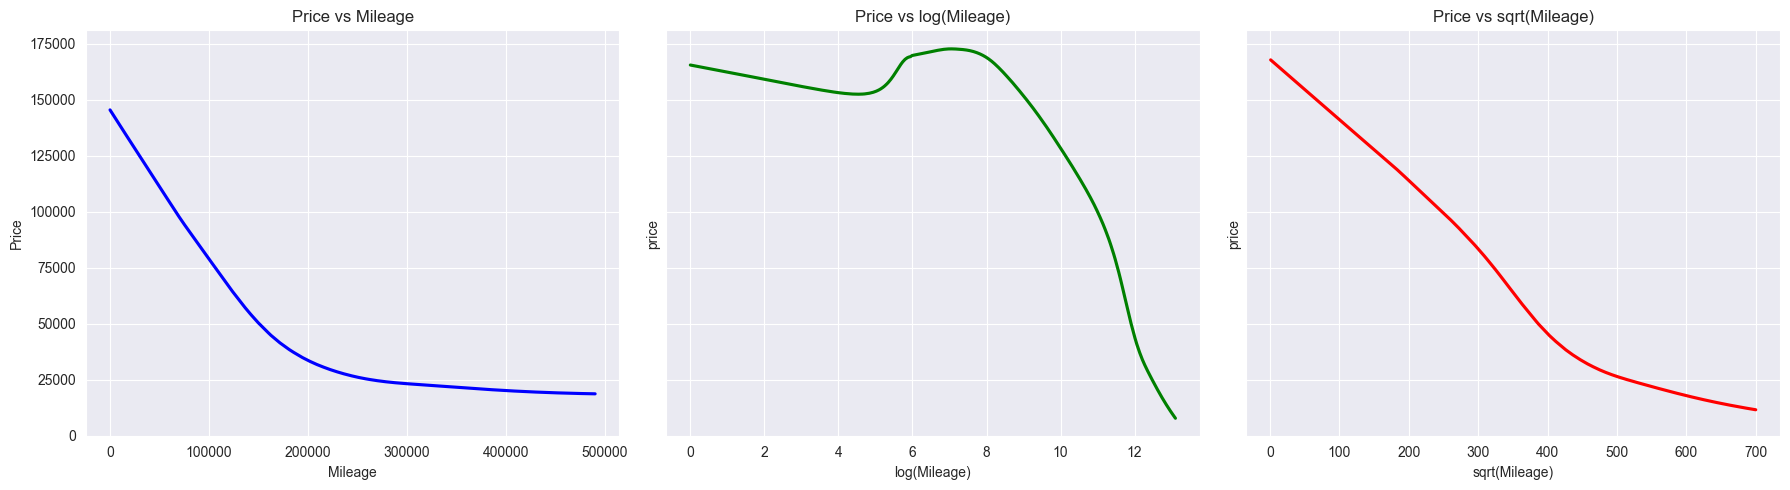

In [21]:
# Drop NaN and non-positive mileage values
filtered_vis = vis_df.dropna(subset=['mileage', 'price'])
filtered_vis = filtered_vis[filtered_vis['mileage'] > 0]

# Remove outliers
q1 = filtered_vis['mileage'].quantile(0.25)
q3 = filtered_vis['mileage'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr
filtered_vis = filtered_vis[(filtered_vis['mileage'] >= lower_bound) & (filtered_vis['mileage'] <= upper_bound)]

# Add transformed columns
filtered_vis['log_mileage'] = np.log(filtered_vis['mileage'])
filtered_vis['sqrt_mileage'] = np.sqrt(filtered_vis['mileage'])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Raw mileage
sns.regplot(
    data=filtered_vis,
    x='mileage',
    y='price',
    lowess=True,
    scatter=False,
    line_kws={'color': 'blue'},
    ax=axes[0]
)
axes[0].set_title("Price vs Mileage")
axes[0].set_xlabel("Mileage")
axes[0].set_ylabel("Price")

# Log mileage
sns.regplot(
    data=filtered_vis,
    x='log_mileage',
    y='price',
    lowess=True,
    scatter=False,
    line_kws={'color': 'green'},
    ax=axes[1]
)
axes[1].set_title("Price vs log(Mileage)")
axes[1].set_xlabel("log(Mileage)")

# Sqrt mileage
sns.regplot(
    data=filtered_vis,
    x='sqrt_mileage',
    y='price',
    lowess=True,
    scatter=False,
    line_kws={'color': 'red'},
    ax=axes[2]
)
axes[2].set_title("Price vs sqrt(Mileage)")
axes[2].set_xlabel("sqrt(Mileage)")

plt.tight_layout()
plt.show()

the price distribution in the different models

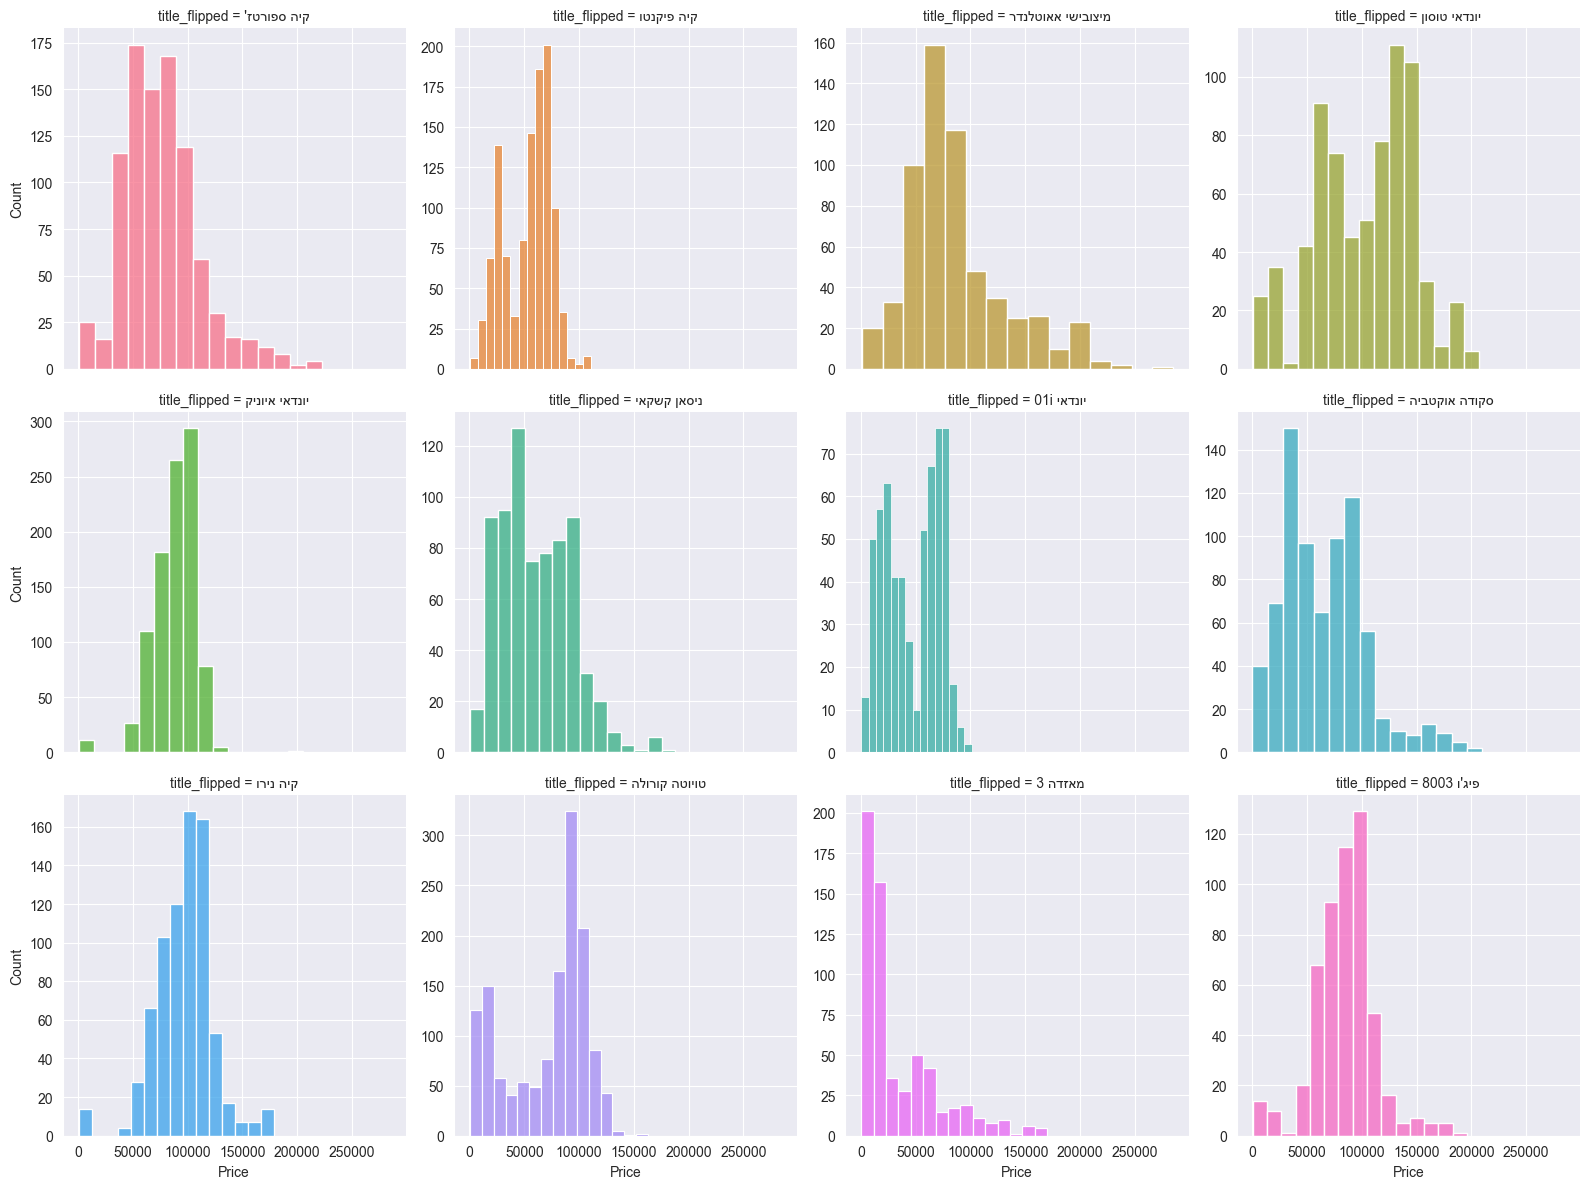

In [22]:
# Get top 20 most frequent titles
top_titles = process_df['title'].value_counts().nlargest(12).index

# Filter dataset for those titles
top_titles_df = process_df[process_df['title'].isin(top_titles)].copy()

# Assuming your function is named flip_hebrew_text
def flip_hebrew_text(text):
    # Your implementation here
    return text[::-1]  # replace with your actual logic

# Apply the flip to the title column
top_titles_df['title_flipped'] = top_titles_df['title'].apply(flip_hebrew_text)

# Create a color palette with as many colors as titles
unique_titles = top_titles_df['title_flipped'].unique()
palette = sns.color_palette("husl", len(unique_titles))  # "husl" gives varied distinct colors
color_dict = dict(zip(unique_titles, palette))

# Create FacetGrid with shared x-axis
g = sns.FacetGrid(
    top_titles_df,
    col="title_flipped",
    col_wrap=4,
    height=4,
    sharex=True,
    sharey=False
)

# Use custom color for each title
def plot_hist(data, color, **kwargs):
    title = data['title_flipped'].iloc[0]
    sns.histplot(data['price'], color=color_dict[title], bins=15, **kwargs)

g.map_dataframe(plot_hist)

# Set axis labels
g.set_axis_labels("Price", "Count")

# Adjust layout
plt.tight_layout()
plt.show()


creat new feature of milage per month to check the relation to the price

In [23]:
# Replace 0 months_on_road with 1 to avoid division by zero
process_df['months_on_road_fixed'] = process_df['months_on_road'].replace(0, 1)

# Calculate mileage per month
process_df['mileage_per_month'] = process_df['mileage'] / process_df['months_on_road_fixed']
process_df['mileage_per_month'].describe()

count     40556.000000
mean       1528.289906
std        1344.910006
min           0.000000
25%        1010.928962
50%        1382.978723
75%        1884.673660
max      185000.000000
Name: mileage_per_month, dtype: float64

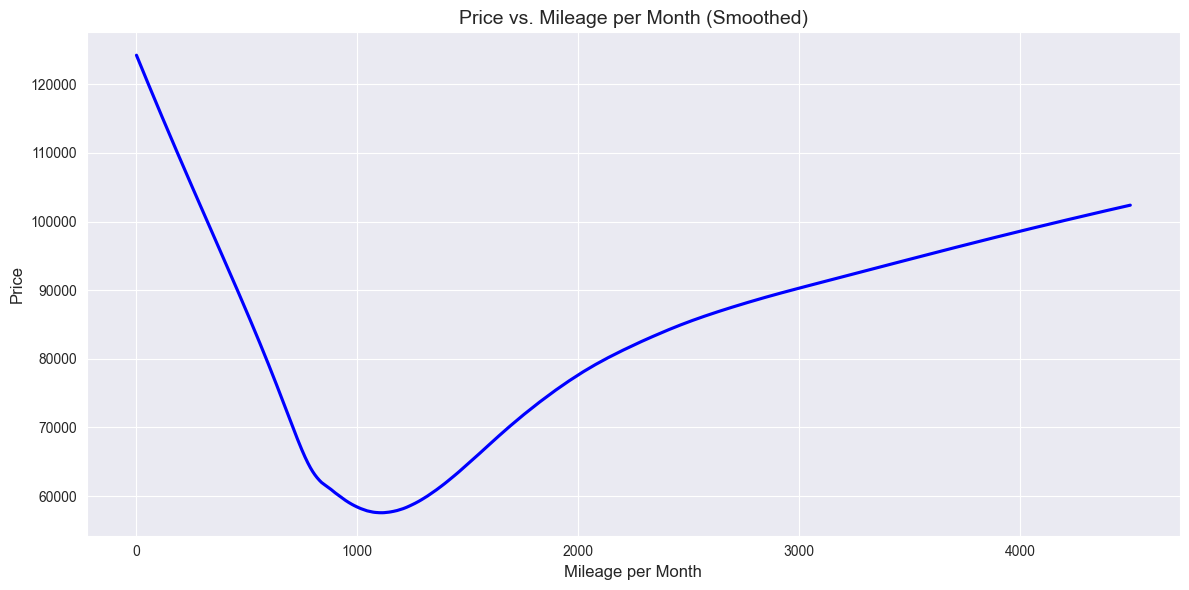

In [24]:
# Drop rows with missing or invalid values
valid_df = process_df.dropna(subset=['price', 'mileage_per_month'])

# Remove outliers in mileage_per_month using IQR
q1 = valid_df['mileage_per_month'].quantile(0.25)
q3 = valid_df['mileage_per_month'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr
filtered_df = valid_df[(valid_df['mileage_per_month'] >= lower_bound) & (valid_df['mileage_per_month'] <= upper_bound)]

# Plot smoothed LOWESS curve
plt.figure(figsize=(12, 6))
sns.regplot(
    data=filtered_df,
    x='mileage_per_month',
    y='price',
    lowess=True,
    scatter=False,
    line_kws={'color': 'blue'}
)
plt.title('Price vs. Mileage per Month (Smoothed)', fontsize=14)
plt.xlabel('Mileage per Month', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

seems like a bad correlation so this feature will be dropped

process the time stamps to informative info for the model

In [25]:
process_df = process_df.drop(['mileage_per_month', 'months_on_road_fixed'], axis=1)

In [26]:
process_df['on_road_year'] = process_df['on_road_date'].dt.year
process_df['on_road_month'] = process_df['on_road_date'].dt.month

In [27]:
# Convert to datetime
process_df['upload_date'] = pd.to_datetime(process_df['upload_date'], errors='coerce')
process_df['test_date'] = pd.to_datetime(process_df['test_date'], errors='coerce')


# Calculate the month difference
process_df['months_to_test'] = (
    (process_df['test_date'].dt.year - process_df['upload_date'].dt.year) * 12 +
    (process_df['test_date'].dt.month - process_df['upload_date'].dt.month)
)

# Optional: handle negative or NaN values if needed
process_df['months_to_test'] = process_df['months_to_test'].clip(lower=0)

### remove collinear features

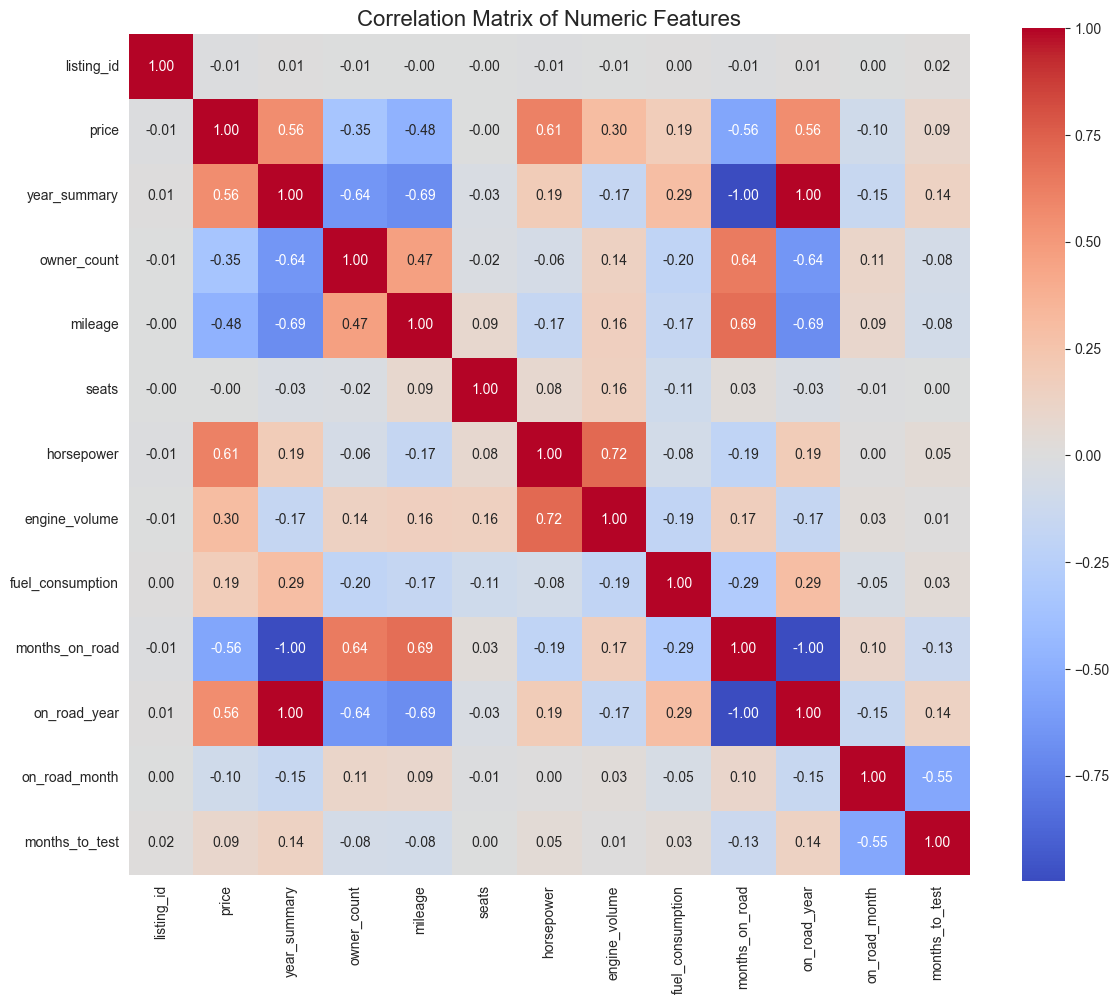

In [28]:
# Compute correlation matrix for numeric columns
correlation_matrix = process_df.corr(numeric_only=True)


# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

as a conclusion from the matrix the year summary column has strong correlation with multiple features so i will drop it
there is also a strong correlation between the milage and the months on road but their both are important and meaningful features so i will keep them fo now

In [29]:
process_df = process_df.drop('year_summary', axis=1)
process_df

,listing_id,upload_date,scrape_date,price,title,owner_count,mileage,color,ownership,test_date,...,seats,horsepower,engine_volume,fuel_consumption,drive_type,url,months_on_road,on_road_year,on_road_month,months_to_test
0,46544667,2025-05-21,25/05/2025,289999.0,ג'יפ גרנד צ'ירוקי,2,70000,כסוף,פרטית,2026-01-05,...,5,295,3604.0,10.00,4X4,https://www.yad2.co.il/vehicles/item/xh2tdvmd?...,36,2022,5,8.0
1,72039716,2025-01-09,25/05/2025,62900.0,מאזדה 2,2,88000,אפור מטאלי,פרטית,2026-01-01,...,5,116,1496.0,20.83,4X2,https://www.yad2.co.il/vehicles/item/iizgzpne?...,60,2020,1,12.0
2,65607492,2025-05-08,25/05/2025,210000.0,ב מ וו סדרה 7,3,110000,שחור,פרטית,NaT,...,5,326,1998.0,40.00,4X4,https://www.yad2.co.il/vehicles/item/vh8136jp?...,83,2018,6,NaN
3,74300037,2025-05-24,25/05/2025,46600.0,קיה ספורטז',2,182000,אפור,פרטית,2026-01-01,...,5,133,1591.0,14.71,4X2,https://www.yad2.co.il/vehicles/item/pxog95kb?...,112,2016,1,8.0
4,82186481,2025-05-16,25/05/2025,80000.0,מרצדס-בנץ CLA,5,170000,לבן,פרטית,2026-01-03,...,5,211,1991.0,17.24,4X2,https://www.yad2.co.il/vehicles/item/nxv8x4jj?...,110,2016,3,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40551,59440427,2025-05-15,24/05/2025,155900.0,טסלה מודל 3,1,40000,לבן שנהב,פרטית,2025-01-08,...,5,498,NaN,NaN,4X4,https://www.yad2.co.il/vehicles/item/9bq9lplx?...,45,2021,8,0.0
40552,69161608,2025-05-07,24/05/2025,82000.0,סיאט אטקה,2,80000,לבן,פרטית,2026-01-02,...,5,150,1395.0,18.18,4X2,https://www.yad2.co.il/vehicles/item/bkslyzsz?...,75,2019,2,8.0
40553,49983040,2025-04-10,24/05/2025,265000.0,לנד רובר ריינג' רובר ספורט,2,100000,לבן שנהב,פרטית,2026-01-04,...,5,258,2993.0,13.70,4X4,https://www.yad2.co.il/vehicles/item/5r2la3ci?...,84,2018,4,9.0
40554,83886243,2025-05-20,24/05/2025,166000.0,סובארו פורסטר,1,31000,שחור,פרטית,2025-01-05,...,5,182,2498.0,14.08,4X4,https://www.yad2.co.il/vehicles/item/5wplx7f2?...,24,2023,5,0.0


as we can see from the data it would be difficult to consider the price elevation in the future because there is not enough 'old' data so i will sample train and test randomly

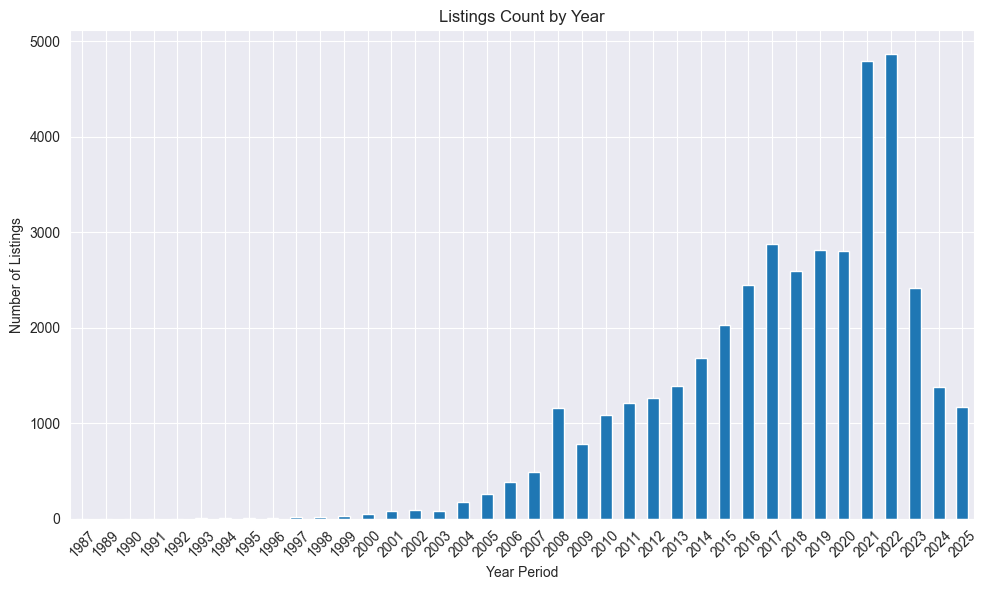

In [31]:
# Drop NaT values
temp_df = process_df.dropna(subset=['on_road_date'])

# Create a new column for 3-month period bins
temp_df['on_road_period'] = temp_df['on_road_date'].dt.to_period('Y')

# Count listings per 3-month period
upload_counts = temp_df['on_road_period'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
upload_counts.plot(kind='bar')
plt.title('Listings Count by Year')
plt.xlabel('Year Period')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### summery:
in this part i did data cleaning and exploratory data analysis
the next step is going to be to train and evaluate a model to predict the car price

In [32]:
process_df.to_csv('processed_data.csv', index=False)